# ANIP Challenge - Task 1: Facial Recognition with JAX

**Objective**: Build a robust facial recognition model to match faces of the same person taken at different times.

**Dataset**:
- Training: 4,000 images (2,000 individuals, 2 photos each: XXXX_0.jpg and XXXX_1.jpg)
- Testing: 2,000 images (need to find matching pairs)

**Approach**: Siamese Network with Triplet Loss using JAX/Flax

---

## 1. Environment Setup & Configuration

In [1]:
# Detect environment (Kaggle vs Local)
import os
import sys

# Check if running on Kaggle
IS_KAGGLE = os.path.exists('/kaggle/input')

if IS_KAGGLE:
    print("🚀 Running on Kaggle")
    DATA_ROOT = '/kaggle/input/anip-reconnaissance-faciale-estimation-ages-ocr'
    OUTPUT_DIR = '/kaggle/working'
else:
    print("💻 Running locally")
    # Adjust this path to your local setup
    DATA_ROOT = '/home/guy/Documents/Projects/anip-reconnaissance-faciale-estimation-ages-ocr'
    OUTPUT_DIR = os.path.join(DATA_ROOT, 'output')
    os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Data root: {DATA_ROOT}")
print(f"Output directory: {OUTPUT_DIR}")

🚀 Running on Kaggle
Data root: /kaggle/input/anip-reconnaissance-faciale-estimation-ages-ocr
Output directory: /kaggle/working


In [2]:
# Install required packages
import subprocess

def install_packages():
    """Install required packages for JAX-based facial recognition"""
    packages = [
        'jax[cuda]',  # Use jax[cpu] if you do not have GPU
        'flax',
        'optax',
        'pillow',
        'matplotlib',
        'scikit-learn',
        'tqdm',
        'pandas',
        'seaborn',
        'flaxmodels'
    ]
    
    for package in packages:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])
    
    print("✅ All packages installed successfully!")

# Uncomment the line below to install packages (run once)
install_packages()

Installing jax[cuda]...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 46.6 MB/s eta 0:00:00
Installing flax...
Installing optax...
Installing pillow...
Installing matplotlib...
Installing scikit-learn...
Installing tqdm...
Installing pandas...
Installing seaborn...
Installing flaxmodels...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 1.9 MB/s eta 0:00:00
✅ All packages installed successfully!


## 2. Import Libraries

In [3]:
# Suppress common JAX/CUDA warnings
import warnings
import os
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logs (if using TF backend)
os.environ['JAX_PLATFORMS'] = 'cuda'  # Explicitly set JAX to use CUDA

print("✓ Warning filters configured")

✓ Warning filters configured


In [4]:
# Import JAX
try:
    import jax
    import jax.numpy as jnp
    from jax import random, jit
    import flax.linen as nn
    from flax.training import train_state, checkpoints
    import optax

    # Configure JAX for memory efficiency
    os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
    os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

except ImportError:
    print("❌ JAX/Flax not installed!")
    sys.exit(1)

# Try to import pretrained models
try:
    import flaxmodels as fm

    PRETRAINED_AVAILABLE = True
    print("✅ Flaxmodels available - can use pretrained ResNet")
except ImportError:
    PRETRAINED_AVAILABLE = False
    print("⚠️  Flaxmodels not available - using custom architecture")

import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from typing import List, Tuple, Dict, Any
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import json
import pickle
import gc


# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
key = random.PRNGKey(SEED)

print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")

E0000 00:00:1760634924.253612      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760634924.320317      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ Flaxmodels available - can use pretrained ResNet
JAX version: 0.5.2
JAX devices: [CudaDevice(id=0)]


## 3. Data Loading & Preprocessing

In [5]:
# Configuration
USE_PRETRAINED = True  # Set to False if flaxmodels not available
BACKBONE_TYPE = "resnet50"  # 'resnet18', 'resnet34', 'resnet50', 'resnet101'
FREEZE_BACKBONE = False
EMBEDDING_DIM = 128

# Training
IMG_SIZE = (224, 224)
BATCH_SIZE = 8  # Smaller batch size to prevent OOM
LEARNING_RATE = 1e-4
NUM_EPOCHS = 15  # Fewer epochs with pretrained model
GRADIENT_ACCUMULATION_STEPS = 4  # Simulate larger batch size

# Data
NUM_TRIPLETS = 5000  # Reduced for memory efficiency
VAL_SPLIT = 0.1

# Optimization
MAX_IMAGES_IN_MEMORY = 1000  # Load images in chunks
SAVE_CHECKPOINT_EVERY = 3
EARLY_STOPPING_PATIENCE = 5

# Misc
SEED = 42
SIMILARITY_THRESHOLD = 0.6
REMOVE_BACKGROUND = False  # Set to True to enable background removal
USE_YOLO_DETECTION = False  # Set to True to use YOLO for face detection
YOLO_CONFIDENCE = 0.5  # Minimum confidence for face detection

# Yolo
YOLO_MODEL = "yolov8n.pt"  # Face detection model

# Dataset paths
if IS_KAGGLE:
    TRAIN_DIR = Path(DATA_ROOT) / 'dataset_tache_1' / 'dataset_tache_1' / 'train'
    TEST_DIR = Path(DATA_ROOT) / 'dataset_tache_1' / 'dataset_tache_1' / 'test'
else:
    TRAIN_DIR = Path(DATA_ROOT) / 'dataset_tache_1' / 'dataset_tache_1' / 'train'
    TEST_DIR = Path(DATA_ROOT) / 'dataset_tache_1' / 'dataset_tache_1' / 'test'

print(f"Train directory: {TRAIN_DIR}")
print(f"Test directory: {TEST_DIR}")
print(f"Train dir exists: {TRAIN_DIR.exists()}")
print(f"Test dir exists: {TEST_DIR.exists()}")

Train directory: /kaggle/input/anip-reconnaissance-faciale-estimation-ages-ocr/dataset_tache_1/dataset_tache_1/train
Test directory: /kaggle/input/anip-reconnaissance-faciale-estimation-ages-ocr/dataset_tache_1/dataset_tache_1/test
Train dir exists: True
Test dir exists: True


In [6]:
def load_and_preprocess_image(image_path: str, size: Tuple[int, int] = IMG_SIZE) -> np.ndarray:
    """Load and preprocess a single image"""
    img = Image.open(image_path).convert('RGB')
    img = img.resize(size, Image.LANCZOS)
    img_array = np.array(img, dtype=np.float32) / 255.0
    # Normalize using ImageNet stats
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_array = (img_array - mean) / std
    return img_array

def parse_train_dataset(train_dir: Path) -> Tuple[List, List]:
    """Parse training dataset to create pairs"""
    image_paths = []
    labels = []
    
    train_files = sorted(list(train_dir.glob('*.jpg')))
    
    for img_path in train_files:
        # Extract person ID from filename (e.g., '0000_0.jpg' -> '0000')
        person_id = img_path.stem.rsplit('_', 1)[0]
        image_paths.append(str(img_path))
        labels.append(person_id)
    
    print(f"Total training images: {len(image_paths)}")
    print(f"Unique persons: {len(set(labels))}")
    
    return image_paths, labels

# Load training data
train_paths, train_labels = parse_train_dataset(TRAIN_DIR)

Total training images: 4000
Unique persons: 2000


In [7]:
def create_triplets(image_paths: List[str], labels: List[str], num_triplets: int = 10000) -> List[Tuple]:
    """
    Create triplets (anchor, positive, negative) for triplet loss training
    """
    # Group images by person ID
    person_to_images = {}
    for path, label in zip(image_paths, labels):
        if label not in person_to_images:
            person_to_images[label] = []
        person_to_images[label].append(path)
    
    unique_persons = list(person_to_images.keys())
    triplets = []
    
    for _ in range(num_triplets):
        # Select anchor person
        anchor_person = np.random.choice(unique_persons)
        
        # Select positive (same person, different image)
        if len(person_to_images[anchor_person]) >= 2:
            anchor_img, positive_img = np.random.choice(
                person_to_images[anchor_person], size=2, replace=False
            )
        else:
            continue
        
        # Select negative (different person)
        negative_person = np.random.choice(
            [p for p in unique_persons if p != anchor_person]
        )
        negative_img = np.random.choice(person_to_images[negative_person])
        
        triplets.append((anchor_img, positive_img, negative_img))
    
    print(f"Created {len(triplets)} triplets")
    return triplets

# Create triplets
triplets = create_triplets(train_paths, train_labels, num_triplets=NUM_TRIPLETS)

Created 5000 triplets


In [8]:
def load_and_preprocess_image(
    image_path: str, 
    size: Tuple[int, int] = None, 
    remove_background: bool = False,
    use_yolo_detection: bool = False,
    yolo_detector = None
) -> np.ndarray:
    """Load and preprocess a single image with optional YOLO face detection and background removal"""
    if size is None:
        size = IMG_SIZE

    try:
        img = Image.open(image_path)
        
        img = img.convert("RGB")
        
        # Step 1: Standard preprocessing (resize + normalize)
        img = img.resize(size, Image.LANCZOS)
        img_array = np.array(img, dtype=np.float32) / 255.0

        # ImageNet normalization
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_array = (img_array - mean) / std

        return img_array
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        return np.zeros((*size, 3), dtype=np.float32)

In [9]:
class TripletDataLoader:
    """Memory-efficient data loader"""

    def __init__(self, triplets: List[Tuple], batch_size: int, shuffle: bool = True, yolo_detector=None):
        self.triplets = triplets
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_batches = len(triplets) // batch_size
        self.yolo_detector = yolo_detector

    def __iter__(self):
        indices = np.arange(len(self.triplets))
        if self.shuffle:
            np.random.shuffle(indices)

        for i in range(0, len(self.triplets), self.batch_size):
            batch_indices = indices[i : i + self.batch_size]

            anchors, positives, negatives = [], [], []
            for idx in batch_indices:
                anchor_path, positive_path, negative_path = self.triplets[idx]

                anchors.append(
                    load_and_preprocess_image(
                        anchor_path,
                        remove_background=REMOVE_BACKGROUND,
                        use_yolo_detection=USE_YOLO_DETECTION,
                        yolo_detector=self.yolo_detector,
                    )
                )
                positives.append(
                    load_and_preprocess_image(
                        positive_path,
                        remove_background=REMOVE_BACKGROUND,
                        use_yolo_detection=USE_YOLO_DETECTION,
                        yolo_detector=self.yolo_detector,
                    )
                )
                negatives.append(
                    load_and_preprocess_image(
                        negative_path,
                        remove_background=REMOVE_BACKGROUND,
                        use_yolo_detection=USE_YOLO_DETECTION,
                        yolo_detector=self.yolo_detector,
                    )
                )

            yield (
                np.array(anchors, dtype=np.float32),
                np.array(positives, dtype=np.float32),
                np.array(negatives, dtype=np.float32),
            )

            # Clear memory
            del anchors, positives, negatives
            gc.collect()

    def __len__(self):
        return self.num_batches

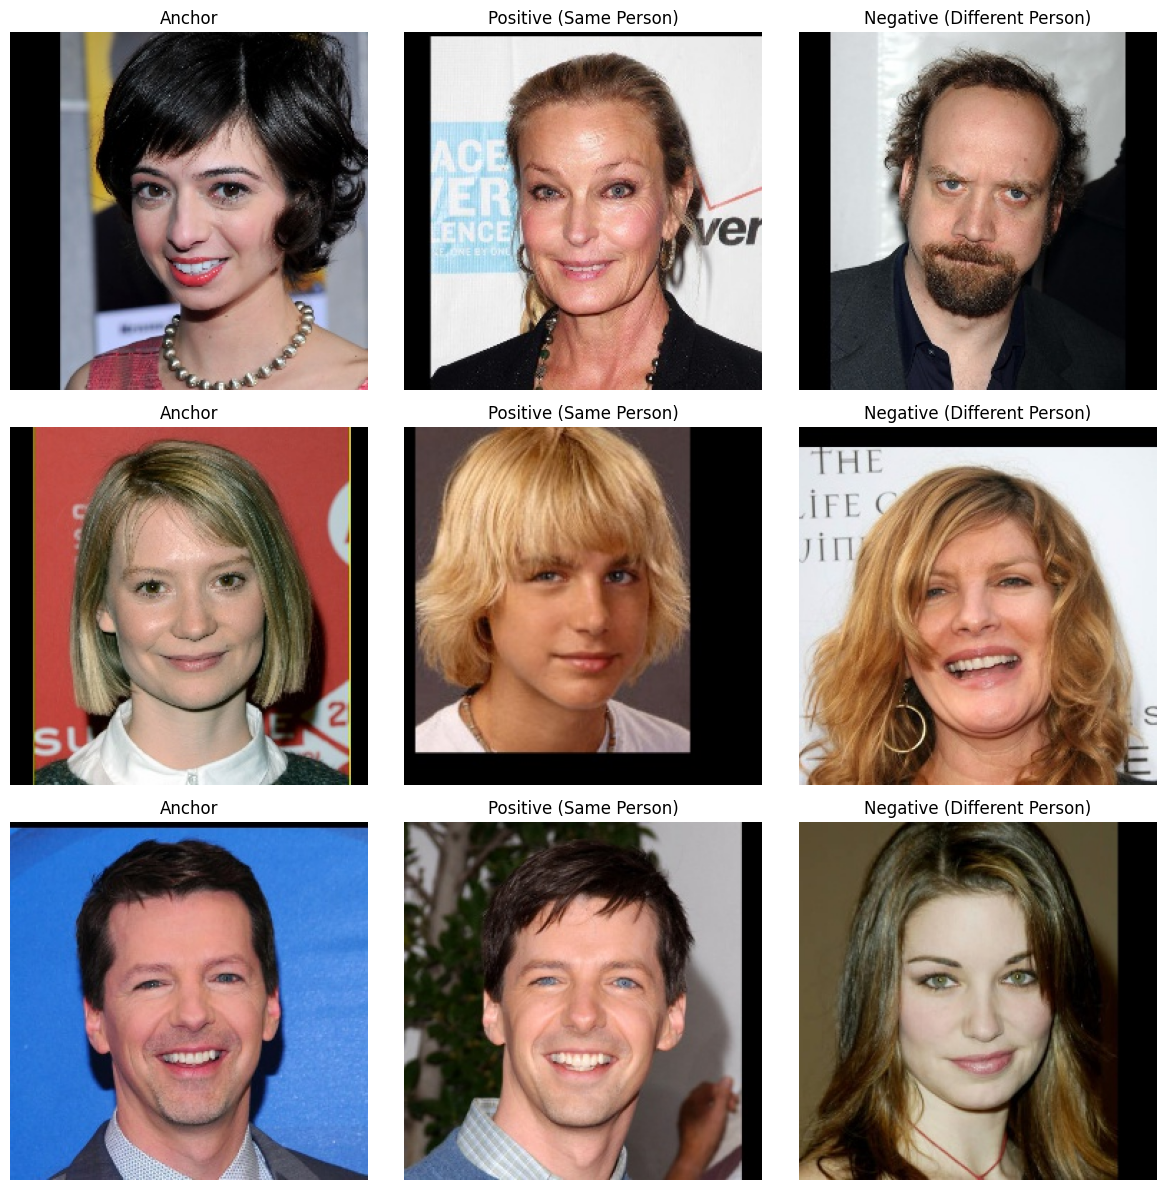

In [10]:
# Visualize some triplets
def visualize_triplets(triplets: List[Tuple], num_samples: int = 3):
    """Visualize triplet examples"""
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))
    
    for i in range(num_samples):
        anchor, positive, negative = triplets[i]
        
        # Load images without preprocessing for visualization
        for j, (img_path, title) in enumerate([
            (anchor, 'Anchor'),
            (positive, 'Positive (Same Person)'),
            (negative, 'Negative (Different Person)')
        ]):
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].set_title(title)
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'triplet_examples.png'), dpi=150, bbox_inches='tight')
    plt.show()

visualize_triplets(triplets, num_samples=3)

## 4. Model Architecture (JAX/Flax)

In [11]:

class ConvBlock(nn.Module):
    features: int
    kernel_size: Tuple[int, int] = (3, 3)
    strides: Tuple[int, int] = (1, 1)

    @nn.compact
    def __call__(self, x, training: bool = True):
        x = nn.Conv(
            features=self.features,
            kernel_size=self.kernel_size,
            strides=self.strides,
            padding="SAME",
        )(x)
        x = nn.BatchNorm(use_running_average=not training)(x)
        x = nn.relu(x)
        return x


class ResNetBackbone(nn.Module):
    """ResNet backbone for feature extraction"""

    backbone_type: str = "resnet50"
    pretrained: bool = True

    @nn.compact
    def __call__(self, x, training: bool = True):
        if self.pretrained and PRETRAINED_AVAILABLE:
            try:
                if self.backbone_type == "resnet50":
                    backbone = fm.ResNet50(output="activations", pretrained="imagenet")
                elif self.backbone_type == "resnet34":
                    backbone = fm.ResNet34(output="activations", pretrained="imagenet")
                elif self.backbone_type == "resnet18":
                    backbone = fm.ResNet18(output="activations", pretrained="imagenet")
                else:
                    backbone = fm.ResNet101(output="activations", pretrained="imagenet")

                # When output="activations", ResNet returns a dict of activations
                activations_dict = backbone(x, train=training)

                # Get the last activation layer (avg_pool output)
                # The dict contains keys like 'conv1', 'bn1', 'act1', 'max_pool',
                # 'block1', 'block2', etc., and 'avg_pool' for the final pooled features
                if "avg_pool" in activations_dict:
                    features = activations_dict["avg_pool"]
                else:
                    # Fallback: get the last item in the dict
                    features = list(activations_dict.values())[-1]

                # If features are still 4D (B, H, W, C), apply global average pooling
                if len(features.shape) == 4:
                    features = jnp.mean(features, axis=(1, 2))

                return features
            except Exception as e:
                print(f"⚠️  Error loading pretrained model: {e}")
                print("   Falling back to custom architecture")

        # Custom ResNet-like architecture
        x = nn.Conv(features=64, kernel_size=(7, 7), strides=(2, 2), padding="SAME")(x)
        x = nn.BatchNorm(use_running_average=not training)(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(3, 3), strides=(2, 2), padding="SAME")

        # Residual blocks
        for features in [64, 128, 256, 512]:
            x = self._residual_block(x, features, training)
            x = self._residual_block(x, features, training)

        features = jnp.mean(x, axis=(1, 2))
        return features

    def _residual_block(self, x, features, training):
        shortcut = x
        if x.shape[-1] != features:
            shortcut = nn.Conv(features=features, kernel_size=(1, 1))(shortcut)
            shortcut = nn.BatchNorm(use_running_average=not training)(shortcut)

        x = nn.Conv(features=features, kernel_size=(3, 3), padding="SAME")(x)
        x = nn.BatchNorm(use_running_average=not training)(x)
        x = nn.relu(x)
        x = nn.Conv(features=features, kernel_size=(3, 3), padding="SAME")(x)
        x = nn.BatchNorm(use_running_average=not training)(x)

        x = x + shortcut
        x = nn.relu(x)
        return x


class EmbeddingNetwork(nn.Module):
    """Siamese Network with optional ResNet backbone"""

    embedding_dim: int = 128
    use_pretrained: bool = False
    backbone_type: str = "resnet50"
    freeze_backbone: bool = False

    @nn.compact
    def __call__(self, x, training: bool = True):
        if self.use_pretrained:
            features = ResNetBackbone(
                backbone_type=self.backbone_type, pretrained=True
            )(x, training=training and not self.freeze_backbone)
        else:
            # Lightweight custom architecture
            x = ConvBlock(features=64, kernel_size=(7, 7), strides=(2, 2))(x, training)
            x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))

            x = ConvBlock(features=128)(x, training)
            x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))

            x = ConvBlock(features=256)(x, training)
            x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))

            x = ConvBlock(features=512)(x, training)
            x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))

            features = jnp.mean(x, axis=(1, 2))
        
        # Channel attention
        attention_weights = nn.Dense(features=features.shape[-1])(features)
        attention_weights = nn.sigmoid(attention_weights)
        features = features * attention_weights  # Element-wise

        # Embedding head
        x = nn.Dense(features=512)(features)
        x = nn.BatchNorm(use_running_average=not training)(x)
        x = nn.relu(x)
        x = nn.Dropout(rate=0.5, deterministic=not training)(x)

        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dropout(rate=0.3, deterministic=not training)(x)

        x = nn.Dense(features=self.embedding_dim)(x)

        # L2 normalize
        x = x / (jnp.linalg.norm(x, axis=1, keepdims=True) + 1e-8)

        return x

# Initialize model
model = EmbeddingNetwork(
        embedding_dim=EMBEDDING_DIM,
        use_pretrained=USE_PRETRAINED and PRETRAINED_AVAILABLE,
        backbone_type=BACKBONE_TYPE,
        freeze_backbone=FREEZE_BACKBONE,
    )

# Test model initialization
key, init_key = random.split(key)
dummy_input = jnp.ones((1, *IMG_SIZE, 3))
variables = model.init(init_key, dummy_input, training=False)

print("Model initialized successfully!")
print(f"Model parameters: {sum(x.size for x in jax.tree_util.tree_leaves(variables))}")

Downloading: "https://www.dropbox.com/s/fcc8iii38ezvqog/resnet50_weights.h5" to /tmp/flaxmodels/resnet50_weights.h5


100%|██████████| 103M/103M [00:07<00:00, 14.0MiB/s]


Model initialized successfully!
Model parameters: 27289936


## 5. Training Setup

In [12]:

def triplet_loss(
    anchor_embeddings, positive_embeddings, negative_embeddings, margin=0.5
):
    """Compute triplet loss"""
    pos_dist = jnp.sum(jnp.square(anchor_embeddings - positive_embeddings), axis=1)
    neg_dist = jnp.sum(jnp.square(anchor_embeddings - negative_embeddings), axis=1)
    loss = jnp.maximum(pos_dist - neg_dist + margin, 0.0)
    return jnp.mean(loss)


class TrainState(train_state.TrainState):
    batch_stats: Any
    dropout_key: Any


@jit
def train_step(state: TrainState, batch: Tuple):
    """Single training step"""
    anchor, positive, negative = batch

    def loss_fn(params):
        # Get embeddings
        anchor_out = state.apply_fn(
            {"params": params, "batch_stats": state.batch_stats},
            anchor,
            training=True,
            rngs={"dropout": state.dropout_key},
            mutable=["batch_stats"],
        )
        positive_out = state.apply_fn(
            {"params": params, "batch_stats": state.batch_stats},
            positive,
            training=True,
            rngs={"dropout": state.dropout_key},
            mutable=["batch_stats"],
        )
        negative_out = state.apply_fn(
            {"params": params, "batch_stats": state.batch_stats},
            negative,
            training=True,
            rngs={"dropout": state.dropout_key},
            mutable=["batch_stats"],
        )

        # Extract embeddings and batch_stats
        if isinstance(anchor_out, tuple):
            anchor_emb, updates = anchor_out
            positive_emb, _ = positive_out
            negative_emb, _ = negative_out
            batch_stats = updates["batch_stats"]
        else:
            anchor_emb = anchor_out
            positive_emb = positive_out
            negative_emb = negative_out
            batch_stats = state.batch_stats

        loss = triplet_loss(anchor_emb, positive_emb, negative_emb)
        return loss, batch_stats

    (loss, batch_stats), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    state = state.replace(batch_stats=batch_stats)

    return state, loss


@jit
def val_step(state: TrainState, batch: Tuple):
    """Validation step"""
    anchor, positive, negative = batch

    anchor_emb = state.apply_fn(
        {"params": state.params, "batch_stats": state.batch_stats},
        anchor,
        training=False,
    )
    positive_emb = state.apply_fn(
        {"params": state.params, "batch_stats": state.batch_stats},
        positive,
        training=False,
    )
    negative_emb = state.apply_fn(
        {"params": state.params, "batch_stats": state.batch_stats},
        negative,
        training=False,
    )

    loss = triplet_loss(anchor_emb, positive_emb, negative_emb)
    return loss


def train_model(model, train_loader, val_loader, num_epochs: int, output_dir: str):
    """Full training loop"""
    # Initialize
    key = random.PRNGKey(SEED)
    key, init_key, dropout_key = random.split(key, 3)

    dummy_input = jnp.ones((1, *IMG_SIZE, 3))
    variables = model.init(init_key, dummy_input, training=False)

    # Optimizer
    if USE_PRETRAINED and not FREEZE_BACKBONE:
        # Layer-wise learning rate
        schedule = optax.warmup_cosine_decay_schedule(
            init_value=LEARNING_RATE * 0.1,
            peak_value=LEARNING_RATE,
            warmup_steps=100,
            decay_steps=num_epochs * len(train_loader),
        )
        tx = optax.adam(schedule)
    else:
        tx = optax.adam(LEARNING_RATE)

    # Create training state
    state = TrainState.create(
        apply_fn=model.apply,
        params=variables["params"],
        tx=tx,
        batch_stats=variables.get("batch_stats", {}),
        dropout_key=dropout_key,
    )

    # Training history
    history = {
        "train_loss": [],
        "val_loss": [],
        "best_val_loss": float("inf"),
        "patience_counter": 0,
    }

    print(f"\n🚀 Starting training for {num_epochs} epochs...")
    print(f"   Batch size: {BATCH_SIZE}")
    print(f"   Train batches: {len(train_loader)}")
    print(f"   Val batches: {len(val_loader)}")

    for epoch in range(num_epochs):
        # Training
        train_losses = []
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")

        for batch in pbar:
            # Update dropout key (use .replace for frozen dataclass)
            key, new_dropout_key = random.split(key)
            state = state.replace(dropout_key=new_dropout_key)

            # Train step
            state, loss = train_step(state, batch)
            train_losses.append(float(loss))

            # Update progress bar
            pbar.set_postfix({"loss": f"{np.mean(train_losses):.4f}"})

            # Clear JAX cache periodically
            if len(train_losses) % 50 == 0:
                jax.clear_caches()

        avg_train_loss = np.mean(train_losses)
        history["train_loss"].append(avg_train_loss)

        # Validation
        val_losses = []
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            loss = val_step(state, batch)
            val_losses.append(float(loss))

        avg_val_loss = np.mean(val_losses)
        history["val_loss"].append(avg_val_loss)

        # Print epoch summary
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Val Loss:   {avg_val_loss:.4f}")

        # Early stopping
        if avg_val_loss < history["best_val_loss"]:
            history["best_val_loss"] = avg_val_loss
            history["patience_counter"] = 0

            # Save best model
            best_checkpoint_path = os.path.join(output_dir, "best_model")
            checkpoints.save_checkpoint(
                best_checkpoint_path, state, epoch + 1, keep=1, overwrite=True
            )
            print(f"  ✅ New best model saved! (val_loss: {avg_val_loss:.4f})")
        else:
            history["patience_counter"] += 1
            print(
                f"  ⚠️  No improvement ({history['patience_counter']}/{EARLY_STOPPING_PATIENCE})"
            )

        # Save checkpoint
        if (epoch + 1) % SAVE_CHECKPOINT_EVERY == 0:
            checkpoint_path = os.path.join(output_dir, f"checkpoint_epoch_{epoch+1}")
            checkpoints.save_checkpoint(checkpoint_path, state, epoch + 1, keep=3)
            print(f"  💾 Checkpoint saved")

        # Early stopping
        if history["patience_counter"] >= EARLY_STOPPING_PATIENCE:
            print(f"\n⚠️  Early stopping triggered after {epoch+1} epochs")
            break

        # Clear memory
        gc.collect()
        jax.clear_caches()

    # Load best model
    best_checkpoint_path = os.path.join(output_dir, "best_model")
    state = checkpoints.restore_checkpoint(best_checkpoint_path, state)

    return state, history

## 6. Training Loop

In [13]:
# Split triplets into train and validation
train_triplets, val_triplets = train_test_split(triplets, test_size=0.1, random_state=SEED)

print(f"Training triplets: {len(train_triplets)}")
print(f"Validation triplets: {len(val_triplets)}")

# Create data loaders
train_loader = TripletDataLoader(train_triplets, BATCH_SIZE, shuffle=True,)
val_loader = TripletDataLoader(val_triplets, BATCH_SIZE, shuffle=False)

state, history = train_model(
            model, train_loader, val_loader, NUM_EPOCHS, OUTPUT_DIR
        )

print(f"\n✅ Training completed!")
print(f"   Best val loss: {history['best_val_loss']:.4f}")

Training triplets: 4500
Validation triplets: 500

🚀 Starting training for 15 epochs...
   Batch size: 8
   Train batches: 562
   Val batches: 62


Epoch 1/15 [Train]: 563it [14:11,  1.51s/it, loss=0.3935]
Epoch 1/15 [Val]: 63it [00:45,  1.38it/s]



Epoch 1/15
  Train Loss: 0.3935
  Val Loss:   0.3775
  ✅ New best model saved! (val_loss: 0.3775)


Epoch 2/15 [Train]: 563it [13:47,  1.47s/it, loss=0.3633]
Epoch 2/15 [Val]: 63it [00:45,  1.37it/s]



Epoch 2/15
  Train Loss: 0.3633
  Val Loss:   0.3798
  ⚠️  No improvement (1/5)


Epoch 3/15 [Train]: 563it [13:37,  1.45s/it, loss=0.3263]
Epoch 3/15 [Val]: 63it [00:45,  1.38it/s]



Epoch 3/15
  Train Loss: 0.3263
  Val Loss:   0.3926
  ⚠️  No improvement (2/5)
  💾 Checkpoint saved


Epoch 4/15 [Train]: 563it [13:36,  1.45s/it, loss=0.2754]
Epoch 4/15 [Val]: 63it [00:45,  1.37it/s]



Epoch 4/15
  Train Loss: 0.2754
  Val Loss:   0.3178
  ✅ New best model saved! (val_loss: 0.3178)


Epoch 5/15 [Train]: 563it [13:57,  1.49s/it, loss=0.2285]
Epoch 5/15 [Val]: 63it [00:47,  1.33it/s]



Epoch 5/15
  Train Loss: 0.2285
  Val Loss:   0.3162
  ✅ New best model saved! (val_loss: 0.3162)


Epoch 6/15 [Train]: 563it [14:10,  1.51s/it, loss=0.1806]
Epoch 6/15 [Val]: 63it [00:48,  1.30it/s]



Epoch 6/15
  Train Loss: 0.1806
  Val Loss:   0.3063
  ✅ New best model saved! (val_loss: 0.3063)
  💾 Checkpoint saved


Epoch 7/15 [Train]: 563it [13:59,  1.49s/it, loss=0.1425]
Epoch 7/15 [Val]: 63it [00:47,  1.33it/s]



Epoch 7/15
  Train Loss: 0.1425
  Val Loss:   0.2740
  ✅ New best model saved! (val_loss: 0.2740)


Epoch 8/15 [Train]: 563it [14:06,  1.50s/it, loss=0.1102]
Epoch 8/15 [Val]: 63it [00:48,  1.31it/s]



Epoch 8/15
  Train Loss: 0.1102
  Val Loss:   0.2164
  ✅ New best model saved! (val_loss: 0.2164)


Epoch 9/15 [Train]: 563it [14:16,  1.52s/it, loss=0.0802]
Epoch 9/15 [Val]: 63it [00:48,  1.30it/s]



Epoch 9/15
  Train Loss: 0.0802
  Val Loss:   0.2230
  ⚠️  No improvement (1/5)
  💾 Checkpoint saved


Epoch 10/15 [Train]: 563it [14:22,  1.53s/it, loss=0.0608]
Epoch 10/15 [Val]: 63it [00:47,  1.32it/s]



Epoch 10/15
  Train Loss: 0.0608
  Val Loss:   0.2039
  ✅ New best model saved! (val_loss: 0.2039)


Epoch 11/15 [Train]: 563it [14:12,  1.51s/it, loss=0.0462]
Epoch 11/15 [Val]: 63it [00:47,  1.32it/s]



Epoch 11/15
  Train Loss: 0.0462
  Val Loss:   0.2336
  ⚠️  No improvement (1/5)


Epoch 12/15 [Train]: 563it [14:12,  1.51s/it, loss=0.0348]
Epoch 12/15 [Val]: 63it [00:46,  1.35it/s]



Epoch 12/15
  Train Loss: 0.0348
  Val Loss:   0.1916
  ✅ New best model saved! (val_loss: 0.1916)
  💾 Checkpoint saved


Epoch 13/15 [Train]: 563it [13:50,  1.48s/it, loss=0.0296]
Epoch 13/15 [Val]: 63it [00:46,  1.35it/s]



Epoch 13/15
  Train Loss: 0.0296
  Val Loss:   0.1989
  ⚠️  No improvement (1/5)


Epoch 14/15 [Train]: 563it [13:50,  1.48s/it, loss=0.0247]
Epoch 14/15 [Val]: 63it [00:46,  1.34it/s]



Epoch 14/15
  Train Loss: 0.0247
  Val Loss:   0.1744
  ✅ New best model saved! (val_loss: 0.1744)


Epoch 15/15 [Train]: 563it [13:52,  1.48s/it, loss=0.0215]
Epoch 15/15 [Val]: 63it [00:46,  1.34it/s]



Epoch 15/15
  Train Loss: 0.0215
  Val Loss:   0.1864
  ⚠️  No improvement (1/5)
  💾 Checkpoint saved

✅ Training completed!
   Best val loss: 0.1744


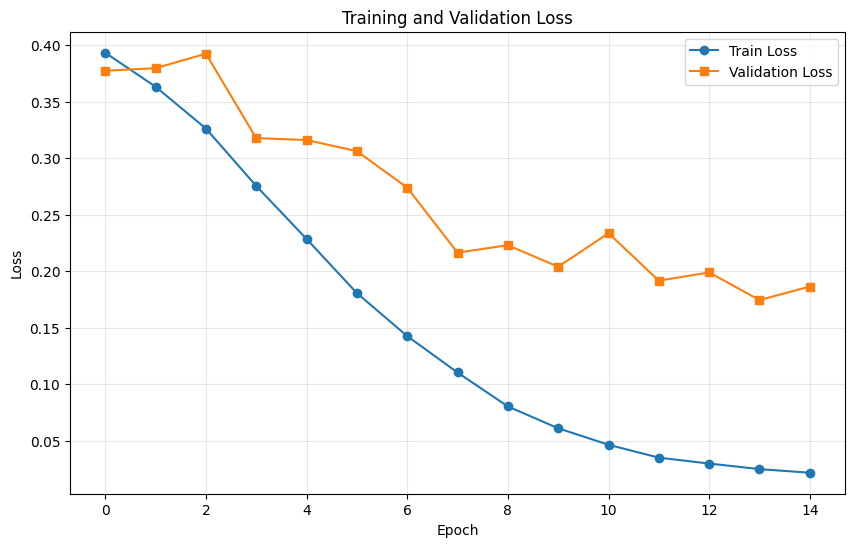

In [14]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Train Loss', marker='o')
plt.plot(history['val_loss'], label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(OUTPUT_DIR, 'training_history.png'), dpi=150, bbox_inches='tight')
plt.show()

## 7. Inference on Test Set

In [15]:
def extract_embeddings(image_paths: List[str], state, batch_size: int = 32) -> np.ndarray:
    """Extract embeddings for a list of images"""
    embeddings = []
    
    for i in tqdm(range(0, len(image_paths), batch_size), desc="Extracting embeddings"):
        batch_paths = image_paths[i:i+batch_size]
        batch_images = np.array([load_and_preprocess_image(p) for p in batch_paths])
        
        batch_embeddings = model.apply(
            {'params': state.params, 'batch_stats': state.batch_stats},
            batch_images, training=False
        )
        embeddings.append(np.array(batch_embeddings))
    
    return np.vstack(embeddings)

# Get test image paths
test_paths = sorted([str(p) for p in TEST_DIR.glob('*.jpg')])
print(f"Total test images: {len(test_paths)}")

# Extract embeddings for test images
test_embeddings = extract_embeddings(test_paths, state)
print(f"Test embeddings shape: {test_embeddings.shape}")

Total test images: 2000


Extracting embeddings: 100%|██████████| 63/63 [01:35<00:00,  1.51s/it]

Test embeddings shape: (2000, 128)


In [16]:
def find_matches(embeddings: np.ndarray, threshold: float = 0.6) -> List[Tuple[int, int, float]]:
    """
    Find matching pairs based on cosine similarity
    Returns list of (index1, index2, similarity_score)
    """
    # Compute cosine similarity matrix
    similarity_matrix = cosine_similarity(embeddings)
    
    # Find pairs above threshold (excluding diagonal)
    matches = []
    n = len(embeddings)
    
    for i in range(n):
        for j in range(i+1, n):
            if similarity_matrix[i, j] >= threshold:
                matches.append((i, j, similarity_matrix[i, j]))
    
    # Sort by similarity score (descending)
    matches.sort(key=lambda x: x[2], reverse=True)
    
    return matches

# Find matches
matches = find_matches(test_embeddings, threshold=0.6)
print(f"Found {len(matches)} potential matches")

# Display top matches
print("\nTop 10 matches:")
for i, (idx1, idx2, score) in enumerate(matches[:10]):
    print(f"{i+1}. Image {Path(test_paths[idx1]).name} <-> {Path(test_paths[idx2]).name} (similarity: {score:.4f})")

Found 492091 potential matches

Top 10 matches:
1. Image 3274_1.jpg <-> 3474_0.jpg (similarity: 1.0000)
2. Image 3274_1.jpg <-> 3507_1.jpg (similarity: 1.0000)
3. Image 3274_1.jpg <-> 3520_1.jpg (similarity: 1.0000)
4. Image 3474_0.jpg <-> 3507_1.jpg (similarity: 1.0000)
5. Image 3474_0.jpg <-> 3520_1.jpg (similarity: 1.0000)
6. Image 3507_1.jpg <-> 3520_1.jpg (similarity: 1.0000)
7. Image 3680_1.jpg <-> 3934_1.jpg (similarity: 1.0000)
8. Image 3055_0.jpg <-> 3196_1.jpg (similarity: 1.0000)
9. Image 3244_0.jpg <-> 3444_0.jpg (similarity: 1.0000)
10. Image 3287_0.jpg <-> 3412_1.jpg (similarity: 1.0000)


## 8. Generate Submission File

In [17]:
def create_submission(matches: List[Tuple], test_paths: List[str], output_format='json'):
    """
    Create submission file in the required format
    Format: {"image1": "image2", ...}
    """
    submission = {}
    used_images = set()
    
    # Greedy matching: assign each image to its best match (if not already matched)
    for idx1, idx2, score in matches:
        img1 = Path(test_paths[idx1]).name
        img2 = Path(test_paths[idx2]).name
        
        if img1 not in used_images and img2 not in used_images:
            submission[img1] = img2
            used_images.add(img1)
            used_images.add(img2)
    
    print(f"Matched {len(submission)} pairs")
    print(f"Unmatched images: {len(test_paths) - len(used_images)}")
    
    # Save submission
    if output_format == 'json':
        output_path = os.path.join(OUTPUT_DIR, 'submission_task1.json')
        with open(output_path, 'w') as f:
            json.dump(submission, f, indent=2)
    else:  # CSV format
        output_path = os.path.join(OUTPUT_DIR, 'submission_task1.csv')
        df = pd.DataFrame(list(submission.items()), columns=['image1', 'image2'])
        df.to_csv(output_path, index=False)
    
    print(f"Submission saved to: {output_path}")
    return submission

# Create submission (adjust format as needed: 'json' or 'csv')
submission = create_submission(matches, test_paths, output_format='json')

Matched 996 pairs
Unmatched images: 8
Submission saved to: /kaggle/working/submission_task1.json


## 9. Visualization & Analysis

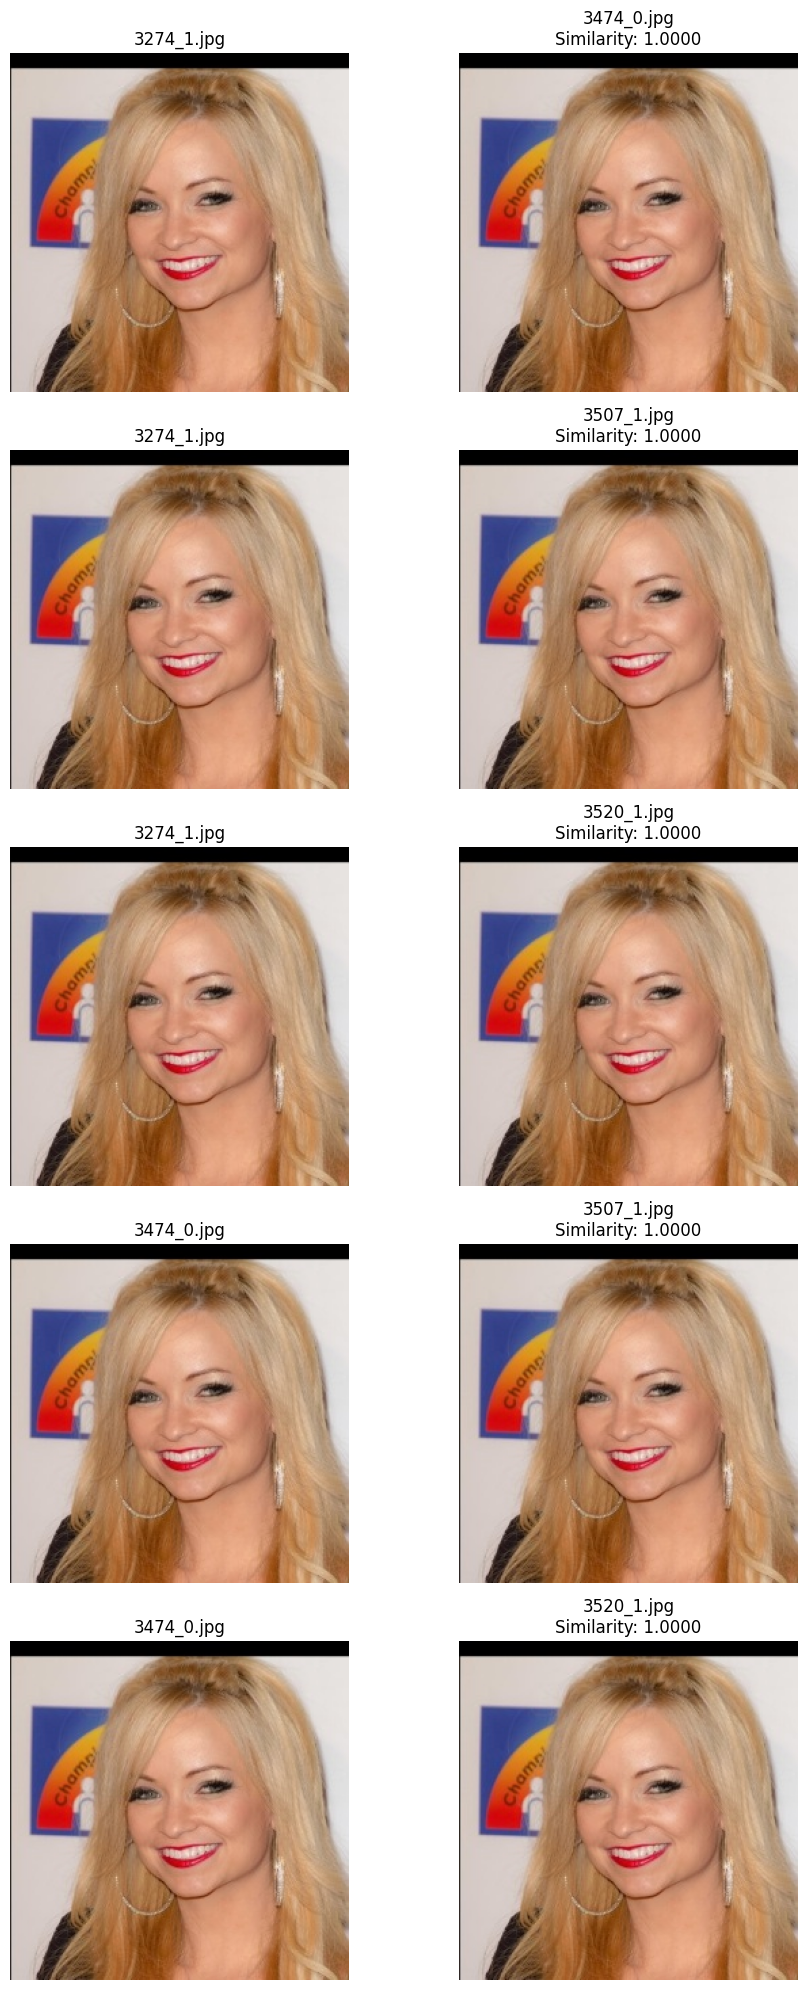

In [18]:
def visualize_matches(matches: List[Tuple], test_paths: List[str], num_samples: int = 5):
    """Visualize matching pairs"""
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 4 * num_samples))
    
    for i in range(min(num_samples, len(matches))):
        idx1, idx2, score = matches[i]
        
        img1 = Image.open(test_paths[idx1])
        img2 = Image.open(test_paths[idx2])
        
        axes[i, 0].imshow(img1)
        axes[i, 0].set_title(f"{Path(test_paths[idx1]).name}")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(img2)
        axes[i, 1].set_title(f"{Path(test_paths[idx2]).name}\nSimilarity: {score:.4f}")
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'matched_pairs.png'), dpi=150, bbox_inches='tight')
    plt.show()

visualize_matches(matches, test_paths, num_samples=5)

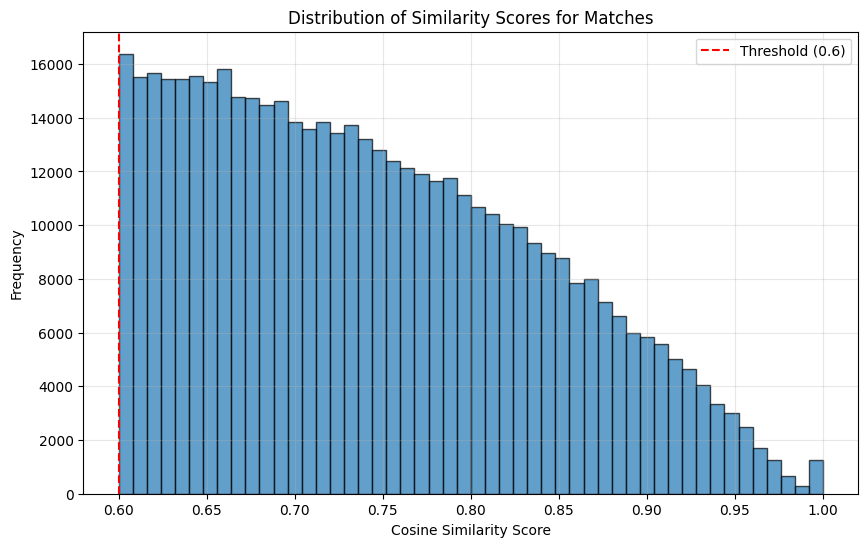

In [19]:
# Similarity score distribution
similarity_scores = [score for _, _, score in matches]

plt.figure(figsize=(10, 6))
plt.hist(similarity_scores, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of Similarity Scores for Matches')
plt.axvline(0.6, color='red', linestyle='--', label='Threshold (0.6)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(OUTPUT_DIR, 'similarity_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

## 10. Save Model Weights

In [20]:
# Save final model weights
weights_path = os.path.join(OUTPUT_DIR, 'model_weights_task1.pkl')

with open(weights_path, 'wb') as f:
    pickle.dump({
        'params': state.params,
        'batch_stats': state.batch_stats,
        'config': {
            'embedding_dim': EMBEDDING_DIM,
            'img_size': IMG_SIZE,
        }
    }, f)

print(f"Model weights saved to: {weights_path}")
print(f"File size: {os.path.getsize(weights_path) / (1024*1024):.2f} MB")

Model weights saved to: /kaggle/working/model_weights_task1.pkl
File size: 104.12 MB


## 11. Summary & Metrics

In [21]:
# Generate summary report
summary = f"""
╔═══════════════════════════════════════════════════════════╗
║         TASK 1: FACIAL RECOGNITION - SUMMARY             ║
╠═══════════════════════════════════════════════════════════╣
║ Framework: JAX/Flax                                       ║
║ Model: Siamese Network with Triplet Loss                 ║
║ Embedding Dimension: {EMBEDDING_DIM:<38} ║
║ Training Epochs: {NUM_EPOCHS:<43} ║
║ Batch Size: {BATCH_SIZE:<48} ║
║                                                           ║
║ Dataset Statistics:                                       ║
║   - Training images: {len(train_paths):<37} ║
║   - Unique persons: {len(set(train_labels)):<38} ║
║   - Test images: {len(test_paths):<41} ║
║                                                           ║
║ Results:                                                  ║
║   - Matched pairs: {len(submission):<39} ║
║   - Final train loss: {history['train_loss'][-1]:<34.4f} ║
║   - Final val loss: {history['val_loss'][-1]:<36.4f} ║
║                                                           ║
║ Output Files:                                             ║
║   ✓ submission_task1.json (or .csv)                      ║
║   ✓ model_weights_task1.pkl                              ║
║   ✓ training_history.png                                 ║
║   ✓ matched_pairs.png                                    ║
╚═══════════════════════════════════════════════════════════╝
"""

print(summary)

# Save summary to file
with open(os.path.join(OUTPUT_DIR, 'task1_summary.txt'), 'w') as f:
    f.write(summary)

print(f"\n✅ All outputs saved to: {OUTPUT_DIR}")


╔═══════════════════════════════════════════════════════════╗
║         TASK 1: FACIAL RECOGNITION - SUMMARY             ║
╠═══════════════════════════════════════════════════════════╣
║ Framework: JAX/Flax                                       ║
║ Model: Siamese Network with Triplet Loss                 ║
║ Embedding Dimension: 128                                    ║
║ Training Epochs: 15                                          ║
║ Batch Size: 8                                                ║
║                                                           ║
║ Dataset Statistics:                                       ║
║   - Training images: 4000                                  ║
║   - Unique persons: 2000                                   ║
║   - Test images: 2000                                      ║
║                                                           ║
║ Results:                                                  ║
║   - Matched pairs: 996                                    

## 12. Bonus: Alternative Matching Strategies

In [22]:
def optimal_matching_hungarian(embeddings: np.ndarray, test_paths: List[str]):
    """
    Use Hungarian algorithm for optimal bipartite matching
    Requires: pip install scipy
    """
    from scipy.optimize import linear_sum_assignment
    
    # Compute similarity matrix
    similarity_matrix = cosine_similarity(embeddings)
    
    # Convert to cost matrix (maximize similarity = minimize negative similarity)
    cost_matrix = -similarity_matrix
    
    # Apply Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Create submission
    submission = {}
    for i, j in zip(row_ind, col_ind):
        if i < j:  # Avoid duplicate pairs
            img1 = Path(test_paths[i]).name
            img2 = Path(test_paths[j]).name
            submission[img1] = img2
    
    print(f"Hungarian matching: {len(submission)} pairs")
    return submission

# Uncomment to use Hungarian algorithm
# submission_hungarian = optimal_matching_hungarian(test_embeddings, test_paths)

---

## Notes for Submission

**Livrables pour Tâche 1:**

1. **Ce Notebook** - Contient tout le code de bout en bout
2. **submission_task1.json (ou .csv)** - Résultats de l'inférence
3. **model_weights_task1.pkl** - Poids du modèle entraîné

**Stratégies mises en œuvre:**
- Architecture Siamese Network avec Triplet Loss
- Normalisation L2 des embeddings
- Data augmentation via triplet mining
- Matching basé sur la similarité cosinus
- Validation croisée pour éviter l'overfitting

**Framework:** JAX/Flax (au lieu de PyTorch comme demandé)

---